# 使用LSTM预测锂离子电池SOC数据
加载已经处理好的锂电池数据，CS2_38.csv数据来源是消费机锂离子电池，soc.csv来源是动力锂电池。
所有原始数据均通过预处理计算成了可直接使用的数据。

## 1、引用相关包数据

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, LSTM
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

## 2、加载数据并将原始数据归一化处理
归一化操作时fit_transform要求输入的数据是二维及以上
这里加载数据，将有效数据从表格中读取出来，然后进行格式转换和归一化，归一化的目的是为了让网络能够更快的拟合
测试数据在原始数据中采用后百分之test_data_rate比例

In [2]:
soc_csv = pd.read_csv('../Data/CS2_38.csv')  # 读文件数据
# soc_csv = pd.read_csv('../Data/soc.csv')  # 读文件数据

test_data_rate = 0.8
training_set = soc_csv['SOC']
test_set = training_set[int(len(training_set)*(1-test_data_rate)):]
training_set, test_set = np.array(training_set), np.array(test_set)

# 归一化
sc = MinMaxScaler(feature_range=(0, 1))  # 定义归一化：归一化到(0，1)之间
training_set_scaled = sc.fit_transform(training_set.reshape(-1, 1))  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
test_set = sc.transform(test_set.reshape(-1, 1))  # 利用训练集的属性对测试集进行归一化

## 3、对原始数据进行分组处理，便于LSTM按照组循环学习数据
测试数据和训练数据需要根据LSTM的要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]
这里使用循环核时间展开步数为lstm_Time_expansion_step
每个时间步输入特征个数为1，即每输入60组数据随后预测下一组数据

In [3]:
x_train = []
y_train = []

x_test = []
y_test = []
lstm_Time_expansion_step = 60

training_data = training_set_scaled[len(training_set_scaled)- int(len(training_set_scaled)/lstm_Time_expansion_step)
                                          *lstm_Time_expansion_step : , :]
test_set = test_set[len(test_set)- int(len(test_set)/lstm_Time_expansion_step)
                                          *lstm_Time_expansion_step : , :]
for i in range(lstm_Time_expansion_step, len(training_data)):
    train_ = training_data[i - lstm_Time_expansion_step:i, 0]
    x_train.append(train_)
    y_train.append(training_data[i, 0])

# 对训练集进行打乱
np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)
# 将训练集由list格式变为array格式
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], lstm_Time_expansion_step, 1))

# 设置测试数据格式
for i in range(lstm_Time_expansion_step, len(test_set)):
    x_test.append(test_set[i - lstm_Time_expansion_step:i, 0])
    y_test.append(test_set[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], lstm_Time_expansion_step, 1))


## 4、构建模型
load_mode可选bool型，当为True时加载上一次的模型继续训练，当为False时从头开始训练
注意：从头开始训练会覆盖原来已有的模型，解决可以修改存储目录

In [4]:
load_mode = False
checkpoint_save_path = "./checkpoint/soc/LSTM_stock.ckpt"   # 保存模型
tf_model_save_path = "./checkpoint/soc/socTFmodel"   # 保存静态模型
log_save_path = "./log/soc/lstm"    # 记录日志

model = tf.keras.Sequential([
    LSTM(60, return_sequences=True),
    Dropout(0.2),
    LSTM(100),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mean_squared_error')  # 损失函数用均方误差
# 该应用只观测loss数值，不观测准确率，所以删去metrics选项，一会在每个epoch迭代显示时只显示loss值

os.makedirs(log_save_path, exist_ok=True)

if load_mode:
    if os.path.exists(checkpoint_save_path + '.index'):
        print('-------------load the model-----------------')
        model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,   # 存储训练过程中loss最优的数据
                                                 monitor='val_loss')    # 使用loss作为存储的评估标准，应为这里没有用参照标签，所以不能使用acc

## 5、训练

In [5]:
history = model.fit(x_train, y_train, batch_size=64, epochs=30, validation_data=(x_test, y_test), validation_freq=1,
                    callbacks=[cp_callback])
model.summary()

Epoch 1/30
15/15 [==============================] - 6s 46ms/step - loss: 0.0741 - val_loss: 0.0126
Epoch 2/30
15/15 [==============================] - 0s 20ms/step - loss: 0.0096 - val_loss: 0.0040
Epoch 3/30
15/15 [==============================] - 0s 20ms/step - loss: 0.0059 - val_loss: 0.0017
Epoch 4/30
15/15 [==============================] - 0s 19ms/step - loss: 0.0042 - val_loss: 0.0010
Epoch 5/30
15/15 [==============================] - 0s 21ms/step - loss: 0.0038 - val_loss: 5.0596e-04
Epoch 6/30
15/15 [==============================] - 0s 21ms/step - loss: 0.0033 - val_loss: 3.5119e-04
Epoch 7/30
15/15 [==============================] - 0s 19ms/step - loss: 0.0028 - val_loss: 3.6868e-04
Epoch 8/30
15/15 [==============================] - 0s 20ms/step - loss: 0.0031 - val_loss: 4.8289e-04
Epoch 9/30
15/15 [==============================] - 0s 20ms/step - loss: 0.0032 - val_loss: 5.2971e-04
Epoch 10/30
15/15 [==============================] - 0s 21ms/step - loss: 0.0026 - val_lo

## 6、保存模型权重
在上面的训练过程中已经使用回调函数存储了index权重，可以重新实例化模型后加载index权重进行前向推理
这里存储的模型是pd格式的静态图，包含了网络结构，权重参数，使用时无需实例化模型，可以直接导入计算，这样设计便于使用部署

In [6]:
model.save(tf_model_save_path, save_format='tf')    # 保存模型为静态权重

file = open(log_save_path+'/weights.txt', 'w')  # 参数提取
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

INFO:tensorflow:Assets written to: ./checkpoint/soc/socTFmodel\assets


INFO:tensorflow:Assets written to: ./checkpoint/soc/socTFmodel\assets


## 7、绘制损失数据曲线

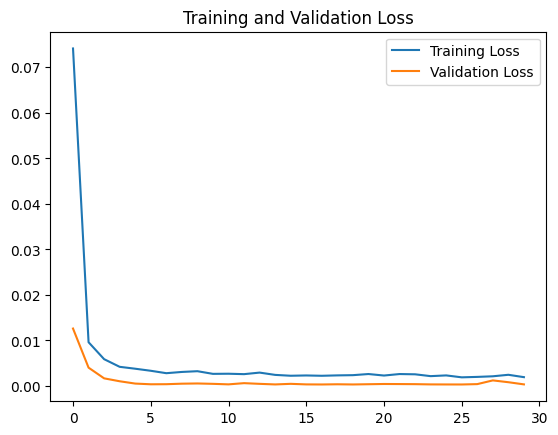

In [7]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training Loss')   # 训练集损失
plt.plot(val_loss, label='Validation Loss') # 验证集损失
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig(log_save_path+"/loss.png", dpi=60)
plt.show()

## 8、预测推理

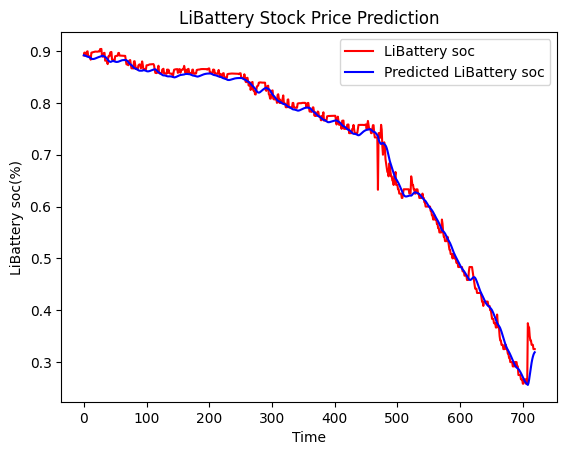

均方误差: 0.000193
均方根误差: 0.013888
平均绝对误差: 0.009344


In [9]:
# 测试集输入模型进行预测
predicted_stock_price = model.predict(x_test)
# 对预测数据还原---从（0，1）反归一化到原始范围
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
# 对真实数据还原---从（0，1）反归一化到原始范围
real_stock_price = sc.inverse_transform(test_set[60:])
# 画出真实数据和预测数据的对比曲线
plt.plot(real_stock_price, color='red', label='LiBattery soc')
plt.plot(predicted_stock_price, color='blue', label='Predicted LiBattery soc')
plt.title('LiBattery Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('LiBattery soc(%)')
plt.legend()
plt.savefig(log_save_path+"/predict.png", dpi=120)
plt.show()

# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(predicted_stock_price, real_stock_price)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt(mean_squared_error(predicted_stock_price, real_stock_price))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(predicted_stock_price, real_stock_price)
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)